<a href="https://colab.research.google.com/github/badhanamitroy/AI-Image-Detector/blob/main/AI_Gen_Image_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI Image Detector')

In [3]:
# import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# ===== CONFIGURATION =====
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 10

In [5]:
# ===== DATA PREPARATION =====
# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test data WITHOUT augmentation (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/AI Image Detector/Train_Data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Load test/validation data
val_data = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/AI Image Detector/Test_Data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Class indices: {train_data.class_indices}")


Found 7704 images belonging to 2 classes.
Found 1926 images belonging to 2 classes.
Training samples: 7704
Validation samples: 1926
Class indices: {'AI-Generated Images': 0, 'Real Images': 1}


In [6]:
# ===== MODEL BUILDING =====
# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  # Increased dropout
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# ===== CALLBACKS =====
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# ===== PHASE 1: TRAIN WITH FROZEN BASE =====
print("\n" + "="*50)
print("PHASE 1: Training with frozen base model")
print("="*50)

model.compile(
    optimizer=Adam(learning_rate=0.001),  # Higher initial LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_phase1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


PHASE 1: Training with frozen base model


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 4900s 20s/step - accuracy: 0.9176 - loss: 0.1839 - val_accuracy: 0.9953 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 2/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 136s 565ms/step - accuracy: 0.9825 - loss: 0.0507 - val_accuracy: 0.9953 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 3/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 136s 564ms/step - accuracy: 0.9889 - loss: 0.0373 - val_accuracy: 0.9938 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 4/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 135s 562ms/step - accuracy: 0.9862 - loss: 0.0343 - val_accuracy: 0.9927 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 5/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 134s 554ms/step - accuracy: 0.9926 - loss: 0.0257 - val_accuracy: 0.9974 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 6/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 132s 549ms/step - accuracy: 0.9901 - loss: 0.0288 - val_accuracy: 0.9953 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 7/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 135s 560ms/step - accurac

In [8]:
# ===== PHASE 2: FINE-TUNING =====
print("\n" + "="*50)
print("PHASE 2: Fine-tuning the model")
print("="*50)

# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze early layers, train only top layers
fine_tune_at = 100  # Unfreeze from this layer onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_phase2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=len(history_phase1.history['loss']),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


PHASE 2: Fine-tuning the model
Epoch 13/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 184s 659ms/step - accuracy: 0.9692 - loss: 0.1116 - val_accuracy: 0.8562 - val_loss: 0.5464 - learning_rate: 1.0000e-04
Epoch 14/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 139s 575ms/step - accuracy: 0.9956 - loss: 0.0179 - val_accuracy: 0.8811 - val_loss: 0.5216 - learning_rate: 1.0000e-04
Epoch 15/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 136s 565ms/step - accuracy: 0.9981 - loss: 0.0045 - val_accuracy: 0.9818 - val_loss: 0.0526 - learning_rate: 1.0000e-04
Epoch 16/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 136s 564ms/step - accuracy: 0.9982 - loss: 0.0059 - val_accuracy: 0.9714 - val_loss: 0.1061 - learning_rate: 1.0000e-04
Epoch 17/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 135s 560ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9958 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 18/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 136s 562ms/step - accuracy: 0.9981 - loss: 0.0036 - val_accuracy: 0.9528 - val_loss: 0.2066 - learning_rate: 1.0000e-04
Ep

In [9]:
# ===== SAVE MODEL =====
model.save('/content/drive/MyDrive/Colab Notebooks/AI Image Detector/ai_image_detector_model.h5')
print("\n✓ Model saved successfully!")


✓ Model saved successfully!


In [10]:
# ===== COMBINE HISTORIES =====
history_combined = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

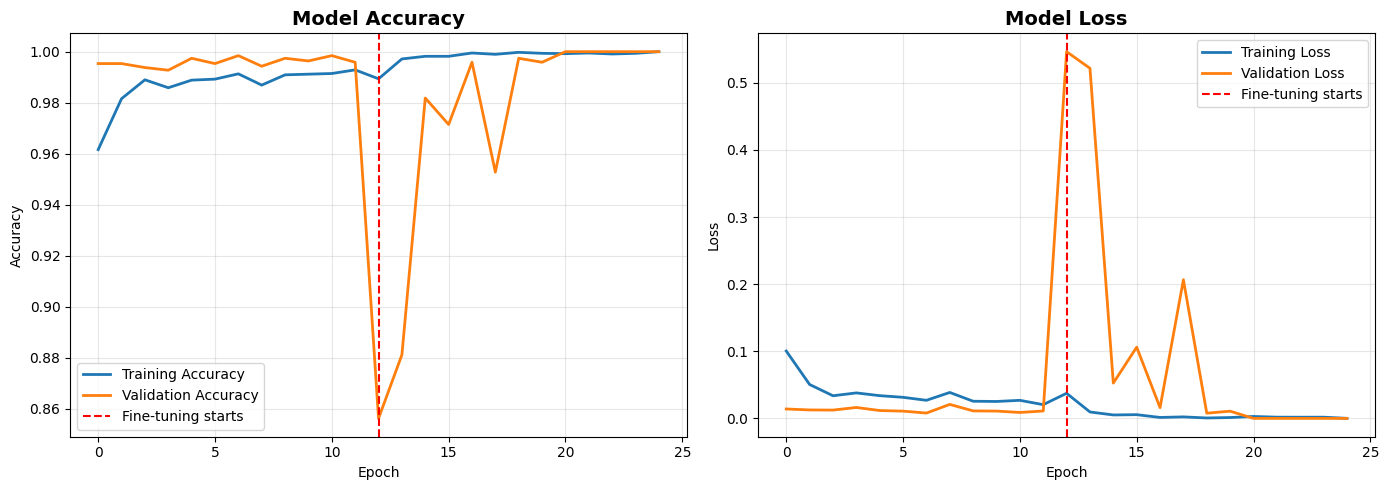

In [11]:
# ===== PLOT TRAINING HISTORY =====
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.axvline(x=len(history_phase1.history['accuracy']), color='r', linestyle='--', label='Fine-tuning starts')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'], label='Training Loss', linewidth=2)
plt.plot(history_combined['val_loss'], label='Validation Loss', linewidth=2)
plt.axvline(x=len(history_phase1.history['loss']), color='r', linestyle='--', label='Fine-tuning starts')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

In [12]:
# ===== EVALUATE MODEL =====
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

val_loss, val_accuracy = model.evaluate(val_data, verbose=1)
print(f"\n✓ Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"✓ Validation Loss: {val_loss:.4f}")


FINAL EVALUATION
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 8.3981e-09

✓ Validation Accuracy: 100.00%
✓ Validation Loss: 0.0000


In [13]:
# ===== PREDICTION FUNCTION =====
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def predict_image(img_path, model=model):
    """
    Predict whether an image is AI-generated or real.

    Args:
        img_path: Path to the image file
        model: Trained model (optional, defaults to current model)

    Returns:
        prediction: Raw prediction value (0-1)
        label: Human-readable label
        confidence: Confidence percentage
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array, verbose=0)[0][0]

    # Get class names (adjust based on your folder structure)
    class_names = list(train_data.class_indices.keys())

    # Determine label based on prediction
    if prediction > 0.5:
        label = class_names[1]  # Class 1
        confidence = prediction
    else:
        label = class_names[0]  # Class 0
        confidence = 1 - prediction

    return prediction, label, confidence


TESTING PREDICTION

Upload an image to test the model:


Saving Finance-Jawad.jpg to Finance-Jawad.jpg

Analyzing: Finance-Jawad.jpg
Raw prediction value: 0.5773
Predicted class: Real Images
Confidence: 57.73%


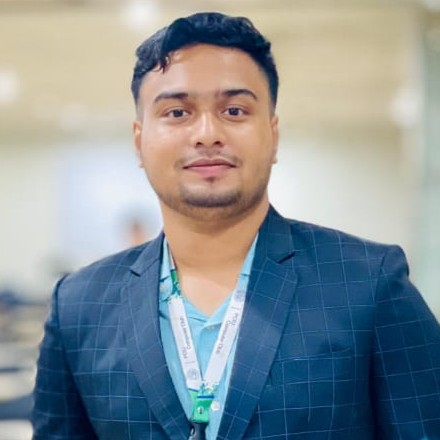


Certainty Level: Low



In [25]:
# ===== TEST PREDICTION FUNCTION =====
print("\n" + "="*50)
print("TESTING PREDICTION")
print("="*50)

from google.colab import files

print("\nUpload an image to test the model:")
uploaded = files.upload()

for fn in uploaded.keys():
    print(f"\n{'='*50}")
    print(f"Analyzing: {fn}")
    print(f"{'='*50}")

    prediction, label, confidence = predict_image(fn)

    print(f"Raw prediction value: {prediction:.4f}")
    print(f"Predicted class: {label}")
    print(f"Confidence: {confidence*100:.2f}%")

    # Display the image
    from IPython.display import display, Image
    display(Image(fn, width=300))

    # Interpretation
    if confidence > 0.9:
        certainty = "Very High"
    elif confidence > 0.75:
        certainty = "High"
    elif confidence > 0.6:
        certainty = "Moderate"
    else:
        certainty = "Low"

    print(f"\nCertainty Level: {certainty}")
    print(f"{'='*50}\n")